# StreamSim: generate stream mocks

Generate stellar stream mock catalogs from configuration files and complete existing tables with missing columns.
**StreamSim** allows sampling of the following quantities:

* (`phi1`, `phi2`): stellar coordinates in the stream frame
* `dist`: distance modulus of stars
* `mag_{band}`: apparent magnitude in a given photometric band of a chosen survey

Future versions may also include sampling of proper motions and velocities.

StreamSim can further convert these intrinsic quantities into **observed quantities**.
For more details, see the notebook *`tutorial_inject_stream.ipynb`*.

**In this tutorial, you’ll learn to:**

* Define model components: density, track, distance modulus, isochrone
* Build or load a configuration and sample a mock catalog
* Complete partial catalogs (e.g., by adding magnitudes)


In [1]:
import sys
import os
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Set the base directory 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(base_dir) # to be able to find ./config/myfile.yaml

# Add base directory to the Python path for imports
sys.path.append(base_dir)

In [2]:
# Import necessary modules form stream_sim
%load_ext autoreload
%autoreload 2
from stream_sim.utils import parse_config
from stream_sim.model import StreamModel

# 1) Build a stream configuration

To set up a stream model, we use a configuration file or dictionary that defines all necessary components. It can include:

* **density** – samples `phi1` values along the stream
* **track** – gives `phi2` as a function of `phi1` (center + spread, using a Gaussian or Uniform sampler)
* **distance_modulus** – defines $DM(phi1)$ for computing apparent magnitudes
* **isochrone** – samples the color–magnitude diagram (required to generate magnitudes)

You can choose how each quantity depends on `phi1` (e.g., constant, linear, spline, etc.).

**Notes:**

* To generate magnitudes, you need at least both `dist` and `isochrone`.
* The velocity model is currently a placeholder (returns NaN).
* Samplers and functions are selected using the `type` keyword (e.g., `"Uniform"`, `"CubicSplineInterpolation"`).



In [3]:
# Build a config dictionary directly

config = { 
          # Density model
          'density': {'type': 'Uniform', 'xmin': -9.0, 'xmax': 9.0}, 

          # Track model
           'track': {'center': {'type': 'Constant', 'value': 0.0}, # center line of the stream in degrees
                     'spread': {'type': 'Constant', 'value': 0.2}, # spread of the stream in degrees
                     'sampler': 'Gaussian'}, # how to sample across the stream

            # Isochrone model
            'isochrone': {'name': 'Bressan2012', # isochrone set name
                          'survey': 'lsst', # survey for filter set
                          'age': 12.0, # Age in Gyr of the population
                          'z': 0.0006, # Metallicity of the population
                          'band_1': 'g', # first band for color-magnitude
                          'band_2': 'r', # second band for color-magnitude
                          'band_1_detection': True}, 

            # Distance modulus model. Here an example of a constant distance modulus
            'distance_modulus': {'center':  {'type': 'Constant', 'value': 16.5}, 
                                 'spread': {'type': 'Constant', 'value': 0.0}, 
                                }
}

# or load from a config file
#config_path = os.path.join(base_dir, 'config', 'toy1_config.yaml')
#config = parse_config(config_path)['stream']

print(config)

{'density': {'type': 'Uniform', 'xmin': -9.0, 'xmax': 9.0}, 'track': {'center': {'type': 'Constant', 'value': 0.0}, 'spread': {'type': 'Constant', 'value': 0.2}, 'sampler': 'Gaussian'}, 'isochrone': {'name': 'Bressan2012', 'survey': 'lsst', 'age': 12.0, 'z': 0.0006, 'band_1': 'g', 'band_2': 'r', 'band_1_detection': True}, 'distance_modulus': {'center': {'type': 'Constant', 'value': 16.5}, 'spread': {'type': 'Constant', 'value': 0.0}}}


In [4]:
# Create stream model and generate stars
stream_model = StreamModel(config)
stream_df = stream_model.sample(4500)

# The dataframe contains: phi1, phi2, distance, magnitudes, etc.
print(f"✓ Generated {len(stream_df)} stars")
print("\nFirst 5 stars:")
print(stream_df.head())

✓ Generated 4500 stars

First 5 stars:
       phi1      phi2  dist   mu1   mu2    rv      mag_g      mag_r
0  4.485923 -0.016508  16.5  None  None  None  27.451787  26.341641
1 -8.720188  0.103825  16.5  None  None  None  26.251991  25.288406
2  0.101823 -0.217297  16.5  None  None  None  30.578660  28.957344
3 -5.860891  0.028019  16.5  None  None  None  27.685134  26.545594
4  5.627263  0.183850  16.5  None  None  None  26.451147  25.462562


Text(0.5, 1.0, 'Color-Magnitude Diagram')

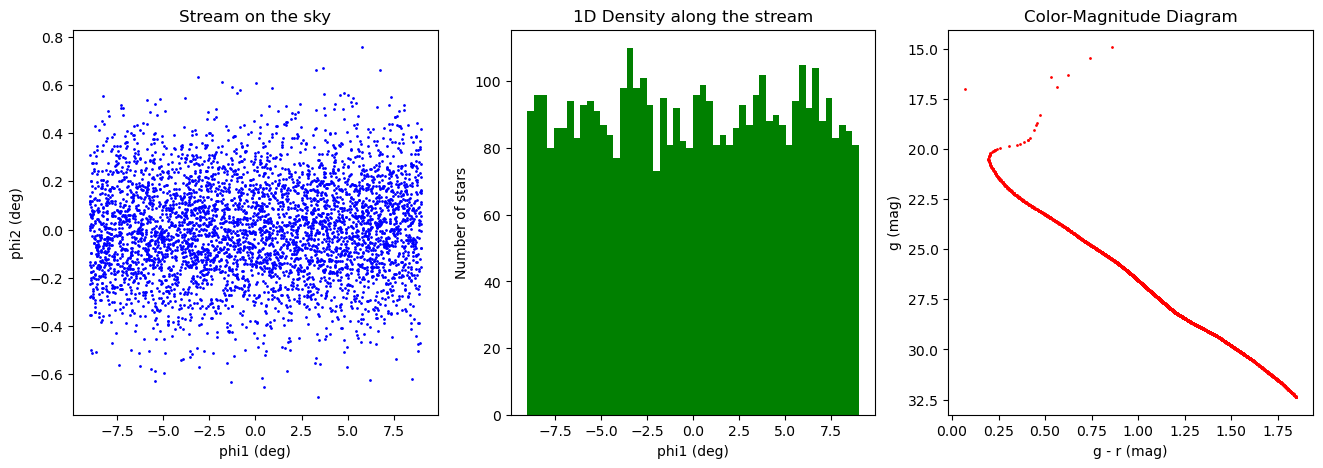

In [5]:
# Quick look: sky track, 1D density, CMD
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# Stream on the sky
ax[0].scatter(stream_df['phi1'], stream_df['phi2'], s=1, color='blue')
ax[0].set_xlabel('phi1 (deg)')
ax[0].set_ylabel('phi2 (deg)')
ax[0].set_title('Stream on the sky')

# 1D density
ax[1].hist(stream_df['phi1'], bins=50, color='green')
ax[1].set_xlabel('phi1 (deg)')
ax[1].set_ylabel('Number of stars')
ax[1].set_title('1D Density along the stream')

# Color-magnitude diagram
ax[2].scatter(stream_df['mag_g'] - stream_df['mag_r'], stream_df['mag_g'], s=1, color='red')
ax[2].set_xlabel('g - r (mag)')
ax[2].set_ylabel('g (mag)')
ax[2].invert_yaxis()
ax[2].set_title('Color-Magnitude Diagram')


## 2) Spline-based configuration

You can model a more realistic stream shape using cubic splines, particularly for:

* **Linear density:** $\sqrt{2\pi} \times \text{peak intensity} \times \text{spread}$
* **Distance modulus**
* **Track and width**

In this example, we use data from `data/patrick_2022_splines.csv` and select `stream == 'phoenix'`.



In [6]:
# Nodes and values for the spline-based stream model (from Patrick et al. 2022, for Phoenix stream)
# One may read these from a CSV file instead of hardcoding them, cf to config/atlas_spline_config.yaml
intensity_nodes = np.array([-13., -9.75, -8.125, -4.1640625, -3.25, -1.625, 1.625, 6.5, 8.125, 13.])
intensity_node_values = np.array([2.35582279e-07, 2.65789495e-02, 5.94765580e-02, 7.20106921e-02, 9.96003626e-02, 4.68656926e-02, 7.42352023e-02, 4.75688845e-06, 1.73046024e-02, 4.08879937e-08])
spread_nodes =  np.array([-13. , 13.])
spread_node_values = np.array([0.0992389,  0.17083177])
center_nodes = np.array([-13., 4.33333333, 13.])
center_node_values = np.array([0.19313599, 0.07139282, 0.60245054])
distance_nodes = np.array([-13., 13.])
distance_node_values = np.array([16.38285347, 16.1136374])


config_spline = {
    # Density model using cubic splines from CSV
    'density': {
        'type': 'lineardensitycubicsplineinterpolation',
        'intensity_nodes': intensity_nodes,
        'intensity_node_values': intensity_node_values,
        'spread_nodes': spread_nodes,
        'spread_node_values': spread_node_values,
    },

    # Track model: center and spread as cubic splines
    'track': {
        'center': {'type': 'CubicSplineInterpolation', 'nodes': center_nodes, 'node_values': center_node_values},
        'spread': {'type': 'CubicSplineInterpolation', 'nodes': spread_nodes, 'node_values': spread_node_values},
    },

    # Isochrone model
    'isochrone': {
        'name': 'Bressan2012',
        'survey': 'lsst',
        'age': 13.0,
        'z': 0.0004,
        'band_1': 'g',
        'band_2': 'r',
        'band_1_detection': True
    },

    # Distance modulus model as a cubic spline (flat default)
    'distance_modulus': {
        'center': {'type': 'CubicSplineInterpolation', 'nodes': distance_nodes, 'node_values': distance_node_values},
        'spread': {'type': 'Constant', 'value': 0.0},
    },
}


In [7]:
# Optional: sample using the spline-based config
stream_model_spline = StreamModel(config_spline)
stream_df_spline = stream_model_spline.sample(4000)

print(f"✓ Generated {len(stream_df_spline)} stars with spline density")
stream_df_spline.head()

✓ Generated 4000 stars with spline density


,phi1,phi2,dist,mu1,mu2,rv,mag_g,mag_r
0,1.391404,0.015682,16.233838,None,None,None,25.960196,24.999889
1,-3.794088,0.067394,16.287531,None,None,None,29.948026,28.391916
2,-2.577016,-0.093431,16.274929,None,None,None,24.916207,24.114676
3,-3.665907,0.027898,16.286204,None,None,None,29.262233,27.815041
4,-3.860129,-0.016211,16.288215,None,None,None,25.088252,24.260884


Text(0.5, 1.0, 'Color-Magnitude Diagram')

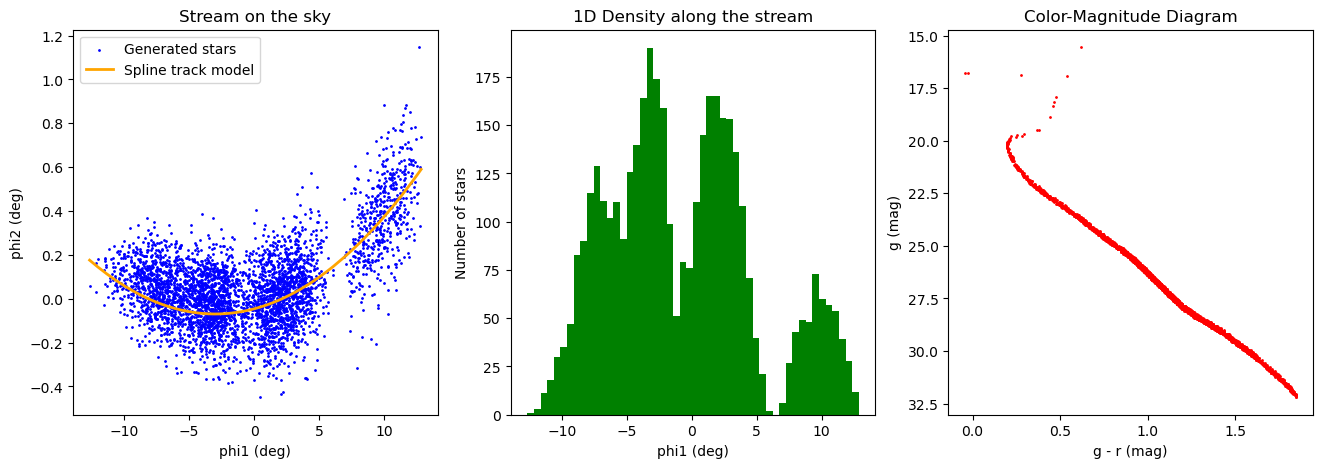

In [8]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# plotting the stream on the sky 
ax[0].scatter(stream_df_spline['phi1'], stream_df_spline['phi2'], s=1, color='blue', label = "Generated stars")
x_val  = np.sort(stream_df_spline['phi1'].values)
spline_val = scipy.interpolate.CubicSpline(center_nodes, center_node_values)(x_val)
ax[0].plot(x_val, spline_val, color='orange', lw=2, label='Spline track model')
ax[0].set_xlabel('phi1 (deg)')
ax[0].set_ylabel('phi2 (deg)')
ax[0].set_title('Stream on the sky')
ax[0].legend()

# Plotting the 1D density along the stream
ax[1].hist(stream_df_spline['phi1'], bins=50, color='green')
ax[1].set_xlabel('phi1 (deg)')
ax[1].set_ylabel('Number of stars')
ax[1].set_title('1D Density along the stream')

# plotting  Color magnitude diagram
ax[2].scatter(stream_df_spline['mag_g'] - stream_df_spline['mag_r'], stream_df_spline['mag_g'], s=1, color='red')
ax[2].set_xlabel('g - r (mag)')
ax[2].set_ylabel('g (mag)')
ax[2].invert_yaxis()
ax[2].set_title('Color-Magnitude Diagram')


# 3) Complete an existing catalog

`StreamModel.complete_catalog` fills only the requested columns while preserving existing values (except for magnitudes and velocities, which are regenerated together for consistency).

* **Dependencies:**

  * `phi2` and `dist` require `phi1`
  * `mags` require both `dist` and `isochrone`
* **Input formats:** can be a `DataFrame`, `dict`, path to a CSV file, or `None` (with a specified `size` to generate the full catalog)


In [9]:
# Let's build a catalog with missing columns to complete
# Here for example we keep only 'phi1' and 'phi2', and drop others
stream_df_sub = stream_df.drop(columns=['mag_r', 'dist', 'mag_g', 'mu1', 'mu2', 'rv' ]).reset_index(drop=True)
print("\nCatalog with missing columns:")
print(stream_df_sub.head())


Catalog with missing columns:
       phi1      phi2
0  4.485923 -0.016508
1 -8.720188  0.103825
2  0.101823 -0.217297
3 -5.860891  0.028019
4  5.627263  0.183850


## Fill every missing columns

In [10]:
# Now we can use `complete_catalog` to fill in the missing columns amoung ['phi1', 'phi2', 'dist', 'mag_g', 'mag_r', 'mu1', 'mu2', 'rv']
completed_catalog = stream_model.complete_catalog(
    catalog=stream_df_sub,
    save_path=None,
    inplace=False,
    verbose=True
)
print(completed_catalog.head())

Velocity model not defined; skipping velocities.
Filled 4500 dist values.
Filled magnitudes for 4500 rows.
       phi1      phi2  dist      mag_g      mag_r
0  4.485923 -0.016508  16.5  26.649565  25.637288
1 -8.720188  0.103825  16.5  29.811375  28.310819
2  0.101823 -0.217297  16.5  27.080248  26.015783
3 -5.860891  0.028019  16.5  27.982069  26.805026
4  5.627263  0.183850  16.5  31.440943  29.701417


## Fill only specific columns

In [11]:
# Example: fill only magnitudes
subset = stream_df_sub.copy()
completed_mags = stream_model.complete_catalog(
    catalog=subset,
    columns_to_add=["mag_g", "mag_r"],
    inplace=False,
    verbose=True,
)
completed_mags.head()

Filled 4500 dist values.
Filled magnitudes for 4500 rows.


,phi1,phi2,dist,mag_g,mag_r
0,4.485923,-0.016508,16.5,25.471623,24.616329
1,-8.720188,0.103825,16.5,27.467190,26.355150
2,0.101823,-0.217297,16.5,28.620544,27.340156
3,-5.860891,0.028019,16.5,28.708652,27.411085
4,5.627263,0.183850,16.5,26.520479,25.523615


*Note: the distance modulus is also added, since it is needed to convert absolute magnitude sampled from the isochrone, to apparent magnitudes (`mag_g`and `mag_r` here).*

## Tips and Troubleshooting

* If magnitudes are missing or NaN, make sure your config includes both `distance_modulus` and `isochrone` sections.
* To keep colors consistent, `complete_catalog` regenerates both `mag_g` and `mag_r` whenever one needs to be computed.
* Column names are automatically standardized (e.g., `'g_mag'` → `'mag_g'`); see `_standardize_columns_name`.
* The velocity model is currently a placeholder and returns NaN values.

# Conclusion

StreamSim provides a flexible framework to build and complete stellar stream mock catalogs, from simple analytic models to spline-based configurations.
Future updates will include proper motions, velocities, and improved documentation for easier user adoption.

You can find more informations in the [full documentation](https://lsstdesc.github.io/stream_sim/).